In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Persona Builder

---





<table align="left">

  <td>
    <a href="https://colab.research.google.com/williamsmt/notebooks/blob/main/persona_builder.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/williamsmt/notebooks/blob/main/persona_builder.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/williamsmt/notebooks/main/persona_builder.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

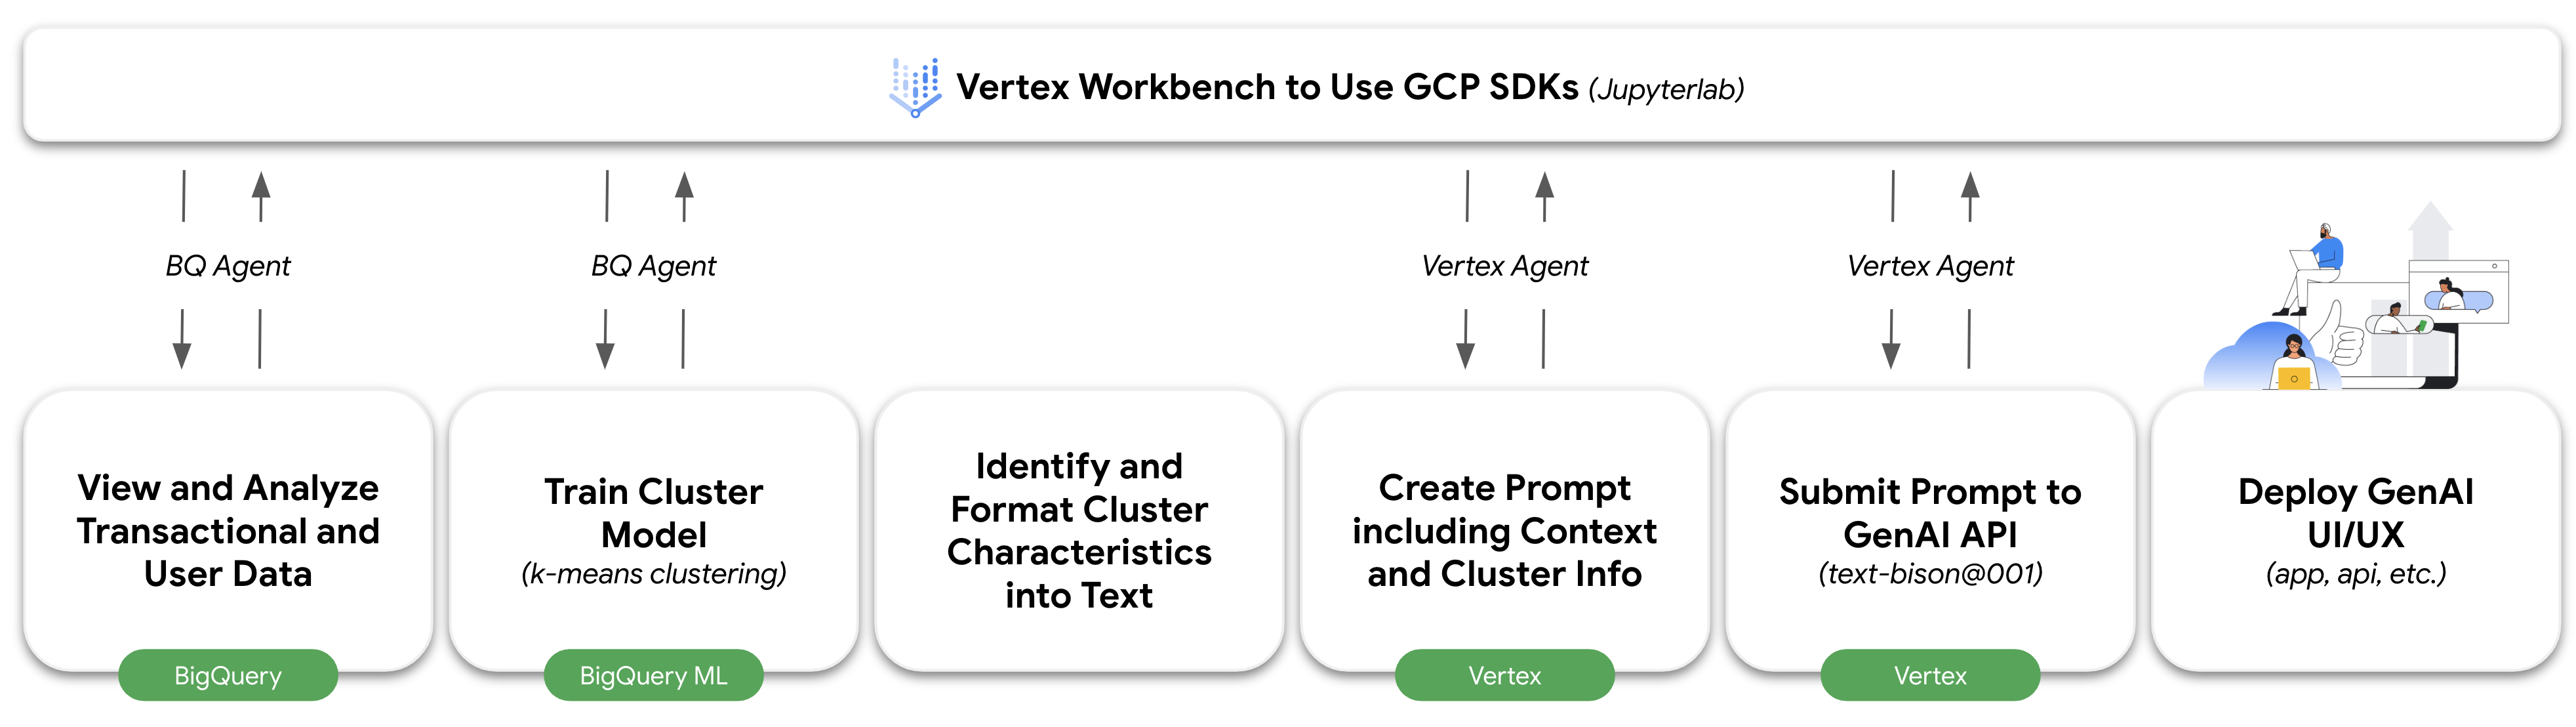

## Overview

This example demonstrates how to cluster eCommerce data into user segments with BQML, then ask Generative AI to create a marketing strategy given our cluster model.

We'll use BigQuery ML to train and test a K-Means cluster that identifies and labels a subset of user personas from our transaction database. This cluster context, along with a defined prompt, will be built on PaLM API to generate a marketing strategy for each cluster.

Learn more about [Vertex AI API](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

### Objective

In this tutorial, you learn how to train and test a K-Means cluster model using BQML, and how to generate a text sample with Vertex AI API given the cluster context:

This tutorial uses the following Google Cloud ML services and resources:

- *Vertex AI*
- *BigQuery*
- *Cloud Storage*


The steps performed include:

- *Query eCommerce data*
- *Cluster eCommerce data with BQML*
- *Create a Vertex AI API prompt with `text-bison@001`*
- *Capture response from PaLM API*

### Dataset

The dataset used in this tutorial is [theLook eCommerce](https://pantheon.corp.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce?authuser=2&organizationId=433637338589&project=askmatt-stuff) from the GCP Marketplace. For demonstration purposes, this dataset was cloned to a private project.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-bigquery

### Colab only: Uncomment the following cell to restart the kernel.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

5. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "askmatt-stuff"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [3]:
from google.colab import auth
auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

- *{Note to notebook author: For any user-provided strings that need to be unique (like bucket names or model ID's), append "-unique" to the end so proper testing can occur}*

In [4]:
BUCKET_URI = f"gs://persona-builder-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [24]:
from google.cloud import aiplatform
from google.cloud import bigquery

from typing import Union

from IPython.display import Markdown

import pandas as pd
import vertexai.preview.language_models

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [23]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)
vertexai.init(project = PROJECT_ID, location = REGION)

### Initialize BigQuery SDK for Python

Initialize the BigQuery SDK for Python for your project.

In [8]:
bq = bigquery.Client(project = PROJECT_ID)

## Tutorial
Now we're ready to create a cluster model that can summarize trends in the transaction data. We'll then send these clusters as context to a PaLM API prompt that will generate a marketing strategy for us.

### View data subset

Let's take a look at the transactional data for a brief reference

In [9]:
query = f"""
SELECT
  user_id,
  order_id,
  sale_price,
  created_at as order_created_date
FROM `{PROJECT_ID}.thelook_ecommerce.order_items`
WHERE created_at BETWEEN CAST('2022-01-01 00:00:00' AS TIMESTAMP)
AND CAST('2024-01-01 00:00:00' AS TIMESTAMP)
"""
df = bq.query(query).to_dataframe()
df.head()

,user_id,order_id,sale_price,order_created_date
0,1787,2161,2.5,2023-04-17 15:08:10+00:00
1,16967,21226,2.5,2022-11-21 04:31:45+00:00
2,9,12,2.5,2023-02-07 22:27:23+00:00
3,63415,79412,3.0,2023-02-11 15:10:40+00:00
4,12610,15789,3.0,2023-03-25 03:48:34+00:00


### Create BQML model
We'll create a simple BQML model using K-Means clustering. The first block sets the `BQML_MODEL` name that will be persisted to the BQ `DATASET`


In [10]:
DATASET = "bqml_demos" #@param {type:"string"}
BQML_MODEL = "ecommerce_customer_segment_cluster5" #@param {type:"string"}

bq.create_dataset(DATASET)


In [11]:
query = f"""
CREATE MODEL IF NOT EXISTS `{DATASET}.{BQML_MODEL}`
OPTIONS (
  MODEL_TYPE = "KMEANS",
  NUM_CLUSTERS = 5,
  KMEANS_INIT_METHOD = "KMEANS++",
  STANDARDIZE_FEATURES = TRUE )
AS (
SELECT * EXCEPT (user_id)
FROM (
  SELECT user_id,
    DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) as DATE), day) AS days_since_order, -- RECENCY
    COUNT(order_id) AS count_orders, -- FREQUENCY
    AVG(sale_price) AS avg_spend -- MONETARY
  FROM (
    SELECT user_id,
      order_id,
      sale_price,
      created_at as order_created_date
    FROM `{PROJECT_ID}.thelook_ecommerce.order_items`
    WHERE created_at BETWEEN CAST('2022-01-01 00:00:00' AS TIMESTAMP)
    AND CAST('2024-01-01 00:00:00' AS TIMESTAMP)
  )
  GROUP BY user_id, order_id
 )
)
"""

In [16]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:

    # Try dry run before executing query to catch any errors
    #job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    #bq.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

In [18]:
%%timeit

run_bq_query(query)

Finished job_id: b0d528b7-88a3-4844-be56-8dbc8bb7152b
Finished job_id: d9f2c2d1-48ca-48d5-b13a-2648e4c5186e
Finished job_id: f3d467c1-8032-4860-bbbd-b2755f6c8c48
Finished job_id: d4a4cf8b-c6e8-438d-af59-150efe7d1603
Finished job_id: 342819fa-f175-423c-b726-f41eef6882b3
Finished job_id: 58b31521-5132-4562-aae9-b9041b037819
Finished job_id: 9fdd0250-51d1-4648-b8ce-43810e842ad8
Finished job_id: 7f8d5315-67a7-44d4-b300-ea7b11836c20
The slowest run took 12.64 times longer than the fastest. This could mean that an intermediate result is being cached.
1.55 s ± 2.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Clustering performance
Let's look at the model's clustering performance using *Davies Bouldin Index and Mean Squared Distance*

In [19]:
query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{DATASET}.{BQML_MODEL}`)
"""

run_bq_query(query)

Finished job_id: 2652f729-83d8-4108-8036-6818878dd8cf


,davies_bouldin_index,mean_squared_distance
0,1.155225,1.505205


#### Output the cluster (centroid) information
Now let's view the five clusters we requested to be defined. This dataframe will represent five clustered personas based on `average_spend`, `count_of_orders`, and `days_since_order`.

In [20]:
query = f"""
SELECT
  CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
  avg_spend as average_spend,
  count_orders as count_of_orders,
  days_since_order
FROM (
  SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
  FROM ML.CENTROIDS(MODEL `{DATASET}.{BQML_MODEL}`)
)
PIVOT (
  SUM(value)
  FOR feature IN ('avg_spend',  'count_orders', 'days_since_order')
)
ORDER BY centroid_id
"""

run_bq_query(query)

Finished job_id: 0c9ec390-c576-4141-9811-40190aae9e04


,centroid,average_spend,count_of_orders,days_since_order
0,cluster 1,129.06,1.18,155.93
1,cluster 2,44.98,1.37,383.77
2,cluster 3,793.39,1.01,218.37
3,cluster 4,40.80,1.57,92.51
4,cluster 5,284.50,1.23,243.66


What exactly does this dataframe represent? Let's explain it in natural language...

In [21]:
df = bq.query(query).to_dataframe()
df.to_string(header=False, index=False)

cluster_info = []
for i, row in df.iterrows():
  cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
    .format(row["centroid"], row["count_of_orders"], row["average_spend"], row["days_since_order"]) )

print(str.join("\n", cluster_info))

cluster 1, average spend $129.06, count of orders per person 1.18, days since last order 155.93
cluster 2, average spend $44.98, count of orders per person 1.37, days since last order 383.77
cluster 3, average spend $793.39, count of orders per person 1.01, days since last order 218.37
cluster 4, average spend $40.8, count of orders per person 1.57, days since last order 92.51
cluster 5, average spend $284.5, count of orders per person 1.23, days since last order 243.66


### Generate marketing strategy
Now let's send these cluster descriptions to `PaLM API` and ask for some creative go-to-market strategies

#### Create the model prompt
This will generate a user-defined `MODEL_PROMPT` for the configured `LLM_BASE_MODEL`

In [25]:
LLM_BASE_MODEL = "text-bison@001" #@param {type:"string"}

textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained(LLM_BASE_MODEL)

In [26]:
MODEL_PROMPT = "Pretend you're a creative strategist, given the following clusters come up with creative brand persona and title labels for each of these clusters, and explain step by step; what would be the next marketing step for these clusters:" #@param {type:"string"}

display(Markdown('## Prompt:'))
print(MODEL_PROMPT)
print('\n')
print(str.join("\n", cluster_info))

## Prompt:

Pretend you're a creative strategist, given the following clusters come up with creative brand persona and title labels for each of these clusters, and explain step by step; what would be the next marketing step for these clusters:


cluster 1, average spend $129.06, count of orders per person 1.18, days since last order 155.93
cluster 2, average spend $44.98, count of orders per person 1.37, days since last order 383.77
cluster 3, average spend $793.39, count of orders per person 1.01, days since last order 218.37
cluster 4, average spend $40.8, count of orders per person 1.57, days since last order 92.51
cluster 5, average spend $284.5, count of orders per person 1.23, days since last order 243.66


#### Capture model response
This response from the LLM will generate the creative marketing strategy for our clustered personas based on their spend habits, namely purchase amount and the frequency.

In [27]:
display(Markdown('## Response:'))
# Send prompt to LLM
display(Markdown(str(textgen_model.predict(
   MODEL_PROMPT + "\n" + str.join("\n", cluster_info),
    max_output_tokens=1024,
    temperature=0.35,
    top_p=0.8,
    top_k=40,
))))

## Response:

**Cluster 1: The Frequent Shopper**

This cluster is made up of customers who spend an average of $129.06 per order and place an order every 155.93 days. They are likely to be loyal customers who are looking for a convenient and affordable way to shop.

**Brand persona:** The Frequent Shopper is a busy person who is always on the go. They are looking for a shopping experience that is easy and hassle-free. They are also looking for value for their money.

**Title label:** The Frequent Shopper

**Next marketing step:** The next marketing step for this cluster is to focus on convenience and value. This could be done by offering free shipping, loyalty programs, or discounts on bulk purchases.

**Cluster 2: The Avid Bargain Hunter**

This cluster is made up of customers who spend an average of $44.98 per order and place an order every 383.77 days. They are likely to be price-conscious shoppers who are looking for the best deals.

**Brand persona:** The Avid Bargain Hunter is a savvy shopper who is always looking for a good deal. They are not afraid to comparison shop and are willing to wait for the best price. They are also likely to be interested in coupons and discounts.

**Title label:** The Avid Bargain Hunter

**Next marketing step:** The next marketing step for this cluster is to focus on discounts and deals. This could be done by offering coupons, sales, or flash sales.

**Cluster 3: The Luxury Shopper**

This cluster is made up of customers who spend an average of $793.39 per order and place an order every 218.37 days. They are likely to be affluent customers who are looking for high-quality products.

**Brand persona:** The Luxury Shopper is a discerning customer who is looking for the best of the best. They are willing to pay a premium for quality and are not afraid to splurge. They are also likely to be interested in new and innovative products.

**Title label:** The Luxury Shopper

**Next marketing step:** The next marketing step for this cluster is to focus on quality and innovation. This could be done by highlighting the high quality of your products and by offering new and innovative products.

**Cluster 4: The Impulsive Shopper**

This cluster is made up of customers who spend an average of $40.80 per order and place an order every 92.51 days. They are likely to be impulse buyers who are looking for a quick and easy shopping experience.

**Brand persona:** The Impulsive Shopper is a busy person who is always on the go. They are looking for a shopping experience that is easy and convenient. They are also likely to be interested in new and exciting products.

**Title label:** The Impulsive Shopper

**Next marketing step:** The next marketing step for this cluster is to focus on convenience and excitement. This could be done by offering a wide variety of products, free shipping, or same-day delivery.

**Cluster 5: The Loyal Customer**

This cluster is made up of customers who spend an average of $284.50 per order and place an order every 243.66 days. They are likely to be loyal customers who are looking for a consistent and reliable shopping experience.

**Brand persona:** The Loyal Customer is a customer who has been with your brand for a long time. They are likely to be satisfied with your products and services and are willing to recommend you to their friends and family.

**Title label:** The Loyal Customer

**Next marketing step:** The next marketing step for this cluster is to focus on loyalty. This could be done by offering loyalty programs, rewards, or discounts.

### Bonus Strategy: Favorite Feature and Email Subject
This model prompts builds on the former by asking for the LLM to incorporate the persona's favorite movie, how it relates to their spending habits, and creates a catchy email subject for a potential marketing campaign.

In [28]:
B1_PROMPT = "Pretend you're a creative strategist, analyse the following clusters and come up with creative brand persona for each that includes the detail of their favorite movie, a summary of how this relates to their purchasing behavior, and a witty e-mail headline for marketing campaign targeted to their group:" #@param {type:"string"}

display(Markdown('## Prompt:'))
print(B1_PROMPT)
print('\n')
print(str.join("\n", cluster_info))
display(Markdown('## Response:'))
display(Markdown(str(textgen_model.predict(
   B1_PROMPT + "\n" + str.join("\n", cluster_info),
    max_output_tokens=1024,
    temperature=0.35,
    top_p=0.8,
    top_k=40,
))))

## Prompt:

Pretend you're a creative strategist, analyse the following clusters and come up with creative brand persona for each that includes the detail of their favorite movie, a summary of how this relates to their purchasing behavior, and a witty e-mail headline for marketing campaign targeted to their group:


cluster 1, average spend $129.06, count of orders per person 1.18, days since last order 155.93
cluster 2, average spend $44.98, count of orders per person 1.37, days since last order 383.77
cluster 3, average spend $793.39, count of orders per person 1.01, days since last order 218.37
cluster 4, average spend $40.8, count of orders per person 1.57, days since last order 92.51
cluster 5, average spend $284.5, count of orders per person 1.23, days since last order 243.66


## Response:

**Cluster 1: The Frequent Shopper**

* Favorite movie: The Princess Bride
* Summary: This group is made up of frequent shoppers who love the movie The Princess Bride. They are typically young professionals who are looking for a good value. They are willing to spend a little more money on a product if it is something they love.
* Witty e-mail headline: "The Princess Bride Fans: Get 20% off your next order!"

**Cluster 2: The Bargain Hunter**

* Favorite movie: The Shawshank Redemption
* Summary: This group is made up of bargain hunters who love the movie The Shawshank Redemption. They are typically older adults who are looking for a good deal. They are willing to wait for a sale or use coupons to get the best price.
* Witty e-mail headline: "The Shawshank Redemption Fans: Save 50% on your next order!"

**Cluster 3: The Luxury Shopper**

* Favorite movie: The Godfather
* Summary: This group is made up of luxury shoppers who love the movie The Godfather. They are typically affluent individuals who are looking for the best quality products. They are willing to pay a high price for a product that is made well and will last.
* Witty e-mail headline: "The Godfather Fans: Treat Yourself to the Best! Get 25% off your next order of luxury goods."

**Cluster 4: The Impulsive Shopper**

* Favorite movie: The Hangover
* Summary: This group is made up of impulsive shoppers who love the movie The Hangover. They are typically young adults who are looking for a good time. They are willing to spend money on impulse purchases without much thought.
* Witty e-mail headline: "The Hangover Fans: Get 10% off your next order of impulse buys!"

**Cluster 5: The Loyal Customer**

* Favorite movie: Star Wars
* Summary: This group is made up of loyal customers who love the movie Star Wars. They are typically families with children who are looking for quality entertainment. They are willing to pay a premium for products that are associated with their favorite movies or brands.
* Witty e-mail headline: "Star Wars Fans: Get a Free Gift with Your Next Order!"

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
import os

# Delete the BQML model
bq.delete_model(f"{DATASET}.{BQML_MODEL}")

# Delete the BQ dataset
bq.delete_dataset(DATASET)

# Delete Cloud Storage objects that were created
delete_bucket = True
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI